# LangGraph Basics - Building a Simple Math Agent

## Step 1: Import dependencies and initialize the LLM

In [5]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

In [6]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "openai:gpt-5-mini",
)

## Step 2: Define tools for arithmetic operations

In [7]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

## Step 3: Bind tools to the LLM

In [8]:
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

## Step 4: Define the agent state

In [9]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

## Step 5: Define the LLM node

In [10]:
from langchain_core.messages import SystemMessage

def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

## Step 6: Define the tool execution node

In [11]:
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

## Step 7: Define the conditional routing logic

In [12]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END

## Step 8: Build the agent graph

In [13]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

## Step 9: Visualize the agent graph

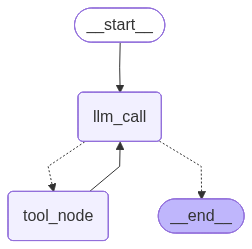

In [14]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Step 10: Run the agent with a sample query

In [15]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_RMETdstMuIzLXb0wqDhjdTA0)
 Call ID: call_RMETdstMuIzLXb0wqDhjdTA0
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

7
